<a href="https://colab.research.google.com/github/ChristopherLiew/Building-A-Generalisable-Red-Wine-Quality-Classifier/blob/master/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Logistic Regression with & without L2 Regularisation</h1>

<h2>Import Libraries & Load the Red Wine Quality dataset</h2>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

In [75]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [76]:
wine_df = pd.read_csv("/content/gdrive/My Drive/Business Analytics Stuff/BT2101 Group Project/winequality-red.csv")
wine_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

<h2>Data Preprocessing</h2>

In [0]:
# Create Binary Target Variable
wine_df['good_quality'] = wine_df['quality'] >= 7
target = wine_df['good_quality'].astype(int)

# Create interaction terms (Domain Knowledge)
features_df = wine_df.iloc[:, :-2]
scaler = MinMaxScaler()
features_df_scaled = pd.DataFrame(scaler.fit_transform(features_df), columns=features_df.columns)
features_df_scaled['total_acidity'] = features_df_scaled['volatile acidity'] + features_df_scaled['fixed acidity']
features_df_scaled['pH_sulphate'] = features_df_scaled['pH']*features_df_scaled['sulphates']

# Feature Selection with ANOVA
anova_results = pd.DataFrame(f_classif(features_df_scaled, target), columns=features_df_scaled.columns)
p_vals = anova_results.iloc[1,:]
selected_features = (p_vals <= 0.05)
selected_features = selected_features[selected_features == True]
feat = p_vals[p_vals <= 0.05]
feat.columns = ["Selected Features", "P-Value"]

# Final unscaled dataset
final_df = wine_df.iloc[:, :-2].copy()
final_df['total_acidity'] = final_df['volatile acidity'] + final_df['fixed acidity']
final_df['pH_sulphate'] = final_df['pH']*final_df['sulphates']
final_df = final_df.loc[:, selected_features.index]
final_df.head()

# Train-Test data
X_test, X_train, y_test, y_train = train_test_split(final_df, target, test_size=0.25, random_state=0)

<h2>Logistic Regression CV</h2>

In [0]:
log_model = LogisticRegressionCV(random_state=0, class_weight="balanced", max_iter=1000)
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

<h2>Evaluating Logistic Regression</h2>

<h3>Classification Report</h3>

In [79]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.950282,0.818890,0.879707,1027.000000
1,0.407643,0.744186,0.526749,172.000000
accuracy,0.808173,0.808173,0.808173,0.808173
macro avg,0.678963,0.781538,0.703228,1199.000000
weighted avg,0.872439,0.808173,0.829074,1199.000000


<h3>ROC AUC</h3>

Random Forest AUROC: 0.852


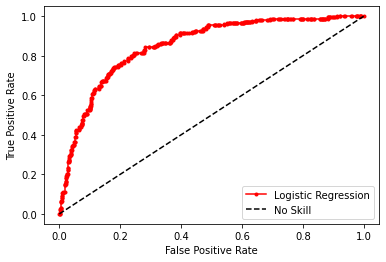

In [80]:
# ROC AUC
# prediction probabilities
log_probs = log_model.predict_proba(X_test)
# generate no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# keep probabilities for the positive outcome only
log_probs = log_probs[:, 1]
# calculate scores
log_auc = roc_auc_score(y_test, log_probs) # AUC = 0.921
ns_auc = roc_auc_score(y_test, ns_probs)
# summarize scores
print('Random Forest AUROC: %.3f' % (log_auc))
# calculate ROC curves
log_fpr, log_tpr, _ = roc_curve(y_test, log_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
# plot the ROC curve for the Random Forest Classifier
#plt.plot([], [], ' ', label="AUROC: 0.921")
plt.plot(log_fpr, log_tpr, marker='.', label='Logistic Regression', color = "red")
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color = "black")
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

<h3>Precision Recall Curve</h3>

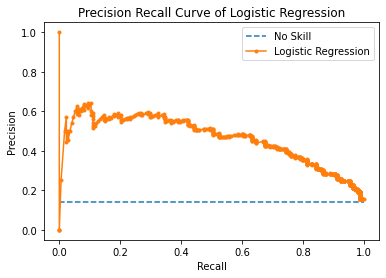

In [81]:
log_probs = log_model.predict_proba(X_test)
log_probs = log_probs[:, 1] # Keep probability predictions for good quality (=1) class only
precisions, recalls, _ = precision_recall_curve(y_test, log_probs)

# Plot PR-Curve
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recalls, precisions, marker='.', label='Logistic Regression')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# annotate optimised model's recall and precision
# Title
plt.title("Precision Recall Curve of Logistic Regression")
# show the plot
plt.show()

<h2>Regularised Logistic Regression</h2>

In [0]:
log_model_reg = LogisticRegressionCV(random_state=0, class_weight="balanced", max_iter=1000, penalty='l2') # Ridge since Shrinkage not needed given VIF 
log_model_reg.fit(X_train, y_train)
y_pred_reg = log_model_reg.predict(X_test)

<h2>Classification Report</h2>

In [83]:
pd.DataFrame(classification_report(y_test, y_pred_reg, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.950282,0.818890,0.879707,1027.000000
1,0.407643,0.744186,0.526749,172.000000
accuracy,0.808173,0.808173,0.808173,0.808173
macro avg,0.678963,0.781538,0.703228,1199.000000
weighted avg,0.872439,0.808173,0.829074,1199.000000


<h3>ROC AUC</h3>

Random Forest AUROC: 0.852


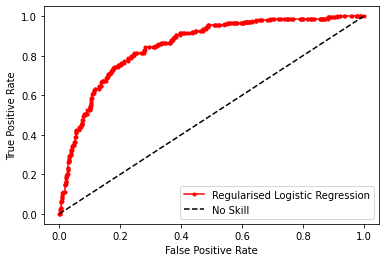

In [84]:
# ROC AUC
# prediction probabilities
log_probs = log_model_reg.predict_proba(X_test)
# generate no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# keep probabilities for the positive outcome only
log_probs = log_probs[:, 1]
# calculate scores
log_auc = roc_auc_score(y_test, log_probs) # AUC = 0.921
ns_auc = roc_auc_score(y_test, ns_probs)
# summarize scores
print('Random Forest AUROC: %.3f' % (log_auc))
# calculate ROC curves
log_fpr, log_tpr, _ = roc_curve(y_test, log_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
# plot the ROC curve for the Random Forest Classifier
#plt.plot([], [], ' ', label="AUROC: 0.921")
plt.plot(log_fpr, log_tpr, marker='.', label='Regularised Logistic Regression', color = "red")
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color = "black")
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

<h3>No difference in results with regularisation</h3>